In [109]:
# For local use, replace google.colab with standard file handling
import os
import cv2
import numpy as np
import mediapipe as mp

In [110]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

## Visualization utilities

In [111]:
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style()
        )
        
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style()
        )
        
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_iris_connections_style()
        )

    return annotated_image

In [112]:
def plot_face_blendshapes_bar_graph(face_blendshapes):

    # Extract the face blendshape categories and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12,12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f'{score:.4f}', va='top')

    ax.set_xlabel('Score')
    ax.set_title('Face Blendshapes')
    plt.tight_layout()
    plt.show()

## Set test image

In [113]:
import os
import cv2
import numpy as np

In [114]:
def load_local_image(image_path):
    """Load image from local file path with proper transparency handling"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Read image with alpha channel (RGBA)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    print(f"Original image shape: {image.shape}")  # Debug info
    
    # Handle different channel counts
    if len(image.shape) == 3:
        if image.shape[2] == 4:  # BGRA format
            print("Processing RGBA image...")
            # Convert BGRA to RGBA
            image_rgba = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
            
            # Create a white background
            height, width = image_rgba.shape[:2]
            background = np.ones((height, width, 3), dtype=np.uint8) * 255
            
            # Extract alpha channel
            alpha = image_rgba[:, :, 3] / 255.0
            
            # Blend foreground with white background using alpha
            for c in range(3):
                background[:, :, c] = (alpha * image_rgba[:, :, c] + 
                                     (1 - alpha) * background[:, :, c])
            
            image_rgb = background.astype(np.uint8)
            print("Applied alpha blending with white background")
            
        elif image.shape[2] == 3:  # BGR format
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print("Converted BGR to RGB")
        else:
            image_rgb = image
    else:
        # Grayscale
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        print("Converted grayscale to RGB")
    
    print(f"Final image shape: {image_rgb.shape}")
    return image_rgb

In [115]:
# Display function replacements for cv2_imshow (Colab-specific)
import matplotlib.pyplot as plt

def show_image(image, title="Image", figsize=(10, 8)):
    """Display image using matplotlib - replacement for cv2_imshow"""
    plt.figure(figsize=figsize)
    
    # Handle different image formats
    if len(image.shape) == 3:
        # Color image - convert BGR to RGB if needed
        if image.shape[2] == 3:
            # Assume BGR format from OpenCV
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image
        plt.imshow(image_rgb)
    else:
        # Grayscale image
        plt.imshow(image, cmap='gray')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

In [116]:
image_path = "../image_processing/out_sample/clipped_images_fg/8104_fg.png"

image = load_local_image(image_path)

Original image shape: (1169, 843, 4)
Processing RGBA image...
Applied alpha blending with white background
Final image shape: (1169, 843, 3)


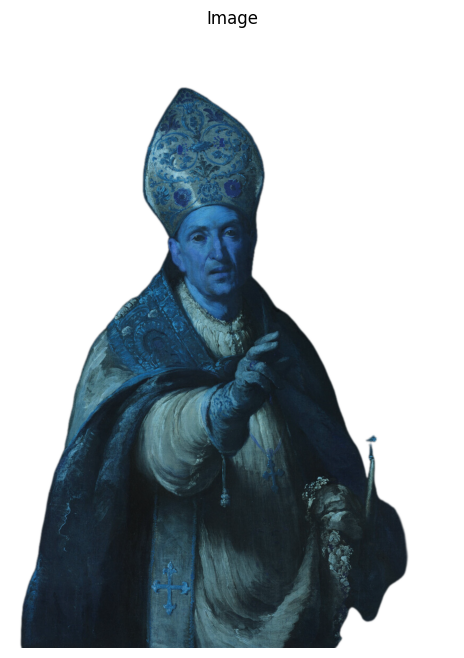

In [117]:
show_image(image)

## Running inference and visualizing the results

In [118]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

Original image shape: (1169, 843, 4)
Processing RGBA image...
Applied alpha blending with white background
Final image shape: (1169, 843, 3)


I0000 00:00:1757444714.354497    3814 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1757444714.354762    3814 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1757444714.358563   35480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1757444714.365364   35500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  wa

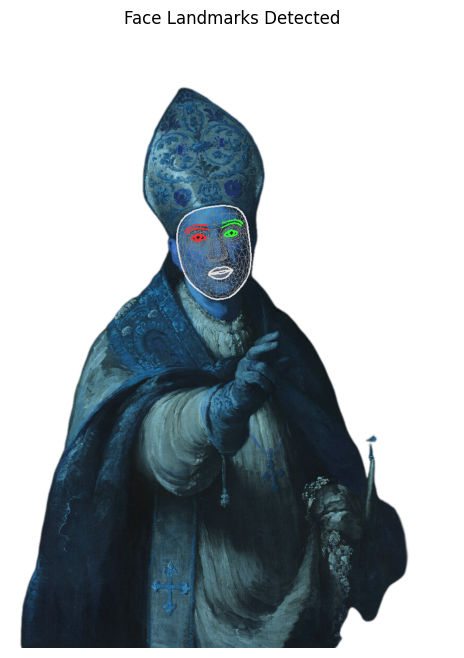

In [119]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image using our local function
image_rgb = load_local_image(image_path)
image_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image_mp)

# STEP 5: Process the detection result. In this case, visualize it.
if detection_result.face_landmarks:
    annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
    show_image(annotated_image, "Face Landmarks Detected")
else:
    print("No face landmarks detected")
    show_image(image_rgb, "Original Image - No Face Detected")

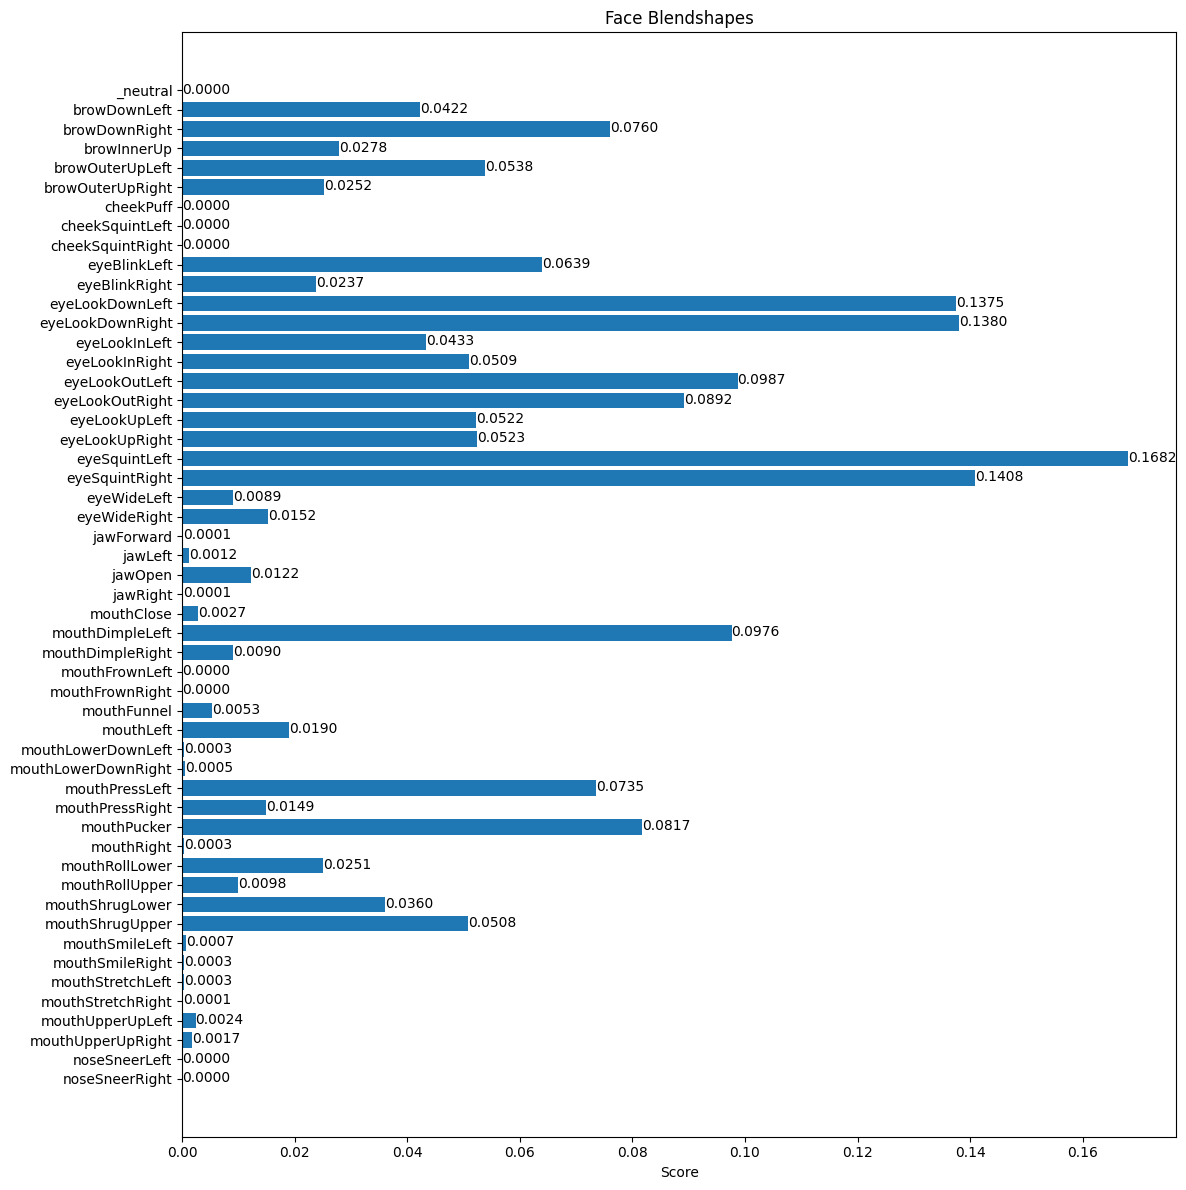

In [120]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [121]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.88215566e-01, -1.36176646e-01,  6.99026063e-02,
        -3.39416671e+00],
       [ 1.40770987e-01,  9.87864435e-01, -6.56346828e-02,
         1.82205105e+01],
       [-6.01163805e-02,  7.47014508e-02,  9.95392501e-01,
        -1.04366196e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


Ï¥ù ÎûúÎìúÎßàÌÅ¨ Í∞úÏàò: 478

=== Ï≤´ 10Í∞ú ÎûúÎìúÎßàÌÅ¨ ÏÉòÌîå ===
Index   0: x=0.473, y=0.383, z=-0.018
Index   1: x=0.469, y=0.368, z=-0.035
Index   2: x=0.470, y=0.373, z=-0.018
Index   3: x=0.460, y=0.349, z=-0.027
Index   4: x=0.468, y=0.362, z=-0.037
Index   5: x=0.467, y=0.354, z=-0.035
Index   6: x=0.464, y=0.335, z=-0.017
Index   7: x=0.412, y=0.337, z=0.006
Index   8: x=0.461, y=0.320, z=-0.013
Index   9: x=0.460, y=0.313, z=-0.015


/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/e

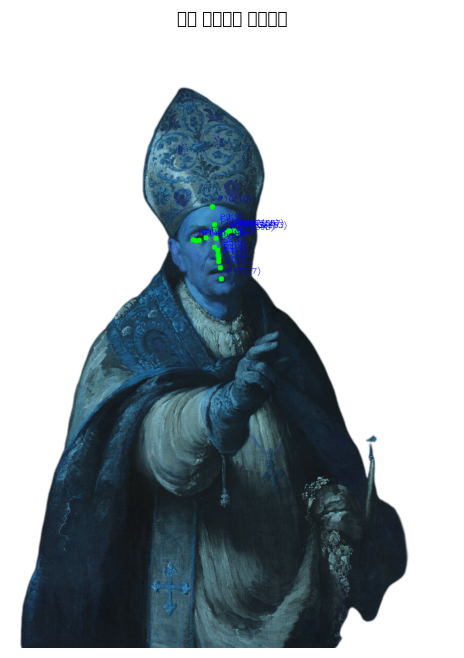


=== ÌÖåÏä§Ìä∏Ìïú Ï£ºÏöî Ìè¨Ïù∏Ìä∏ Ï¢åÌëú ===
Index   0: ÌîΩÏÖÄ( 398,  447) | Ï†ïÍ∑úÌôî(0.473, 0.383)
Index   1: ÌîΩÏÖÄ( 395,  430) | Ï†ïÍ∑úÌôî(0.469, 0.368)
Index   2: ÌîΩÏÖÄ( 395,  435) | Ï†ïÍ∑úÌôî(0.470, 0.373)
Index   3: ÌîΩÏÖÄ( 387,  408) | Ï†ïÍ∑úÌôî(0.460, 0.349)
Index   4: ÌîΩÏÖÄ( 394,  423) | Ï†ïÍ∑úÌôî(0.468, 0.362)
Index   5: ÌîΩÏÖÄ( 393,  414) | Ï†ïÍ∑úÌôî(0.467, 0.354)
Index   6: ÌîΩÏÖÄ( 390,  391) | Ï†ïÍ∑úÌôî(0.464, 0.335)
Index   7: ÌîΩÏÖÄ( 347,  394) | Ï†ïÍ∑úÌôî(0.412, 0.337)
Index   8: ÌîΩÏÖÄ( 388,  374) | Ï†ïÍ∑úÌôî(0.461, 0.320)
Index   9: ÌîΩÏÖÄ( 387,  365) | Ï†ïÍ∑úÌôî(0.460, 0.313)


In [122]:
# Ïã§Ï†ú ÎûúÎìúÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
if detection_result.face_landmarks:
    landmarks = detection_result.face_landmarks[0]
    print(f"Ï¥ù ÎûúÎìúÎßàÌÅ¨ Í∞úÏàò: {len(landmarks)}")
    
    # Î™á Í∞úÏùò ÎûúÎìúÎßàÌÅ¨ Ìè¨Ïù∏Ìä∏ ÏÉòÌîå Ï∂úÎ†•
    print("\n=== Ï≤´ 10Í∞ú ÎûúÎìúÎßàÌÅ¨ ÏÉòÌîå ===")
    for i in range(min(10, len(landmarks))):
        landmark = landmarks[i]
        print(f"Index {i:3d}: x={landmark.x:.3f}, y={landmark.y:.3f}, z={landmark.z:.3f}")
    
    # Ïù¥ÎØ∏ÏßÄÏóêÏÑú ÌäπÏ†ï Ìè¨Ïù∏Ìä∏Îì§ÏùÑ ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌïú Ìï®Ïàò
    def visualize_specific_points(image, landmarks, point_indices, labels):
        """ÌäπÏ†ï ÎûúÎìúÎßàÌÅ¨ Ìè¨Ïù∏Ìä∏Îì§ÏùÑ Ïù¥ÎØ∏ÏßÄÏóê ÌëúÏãú"""
        annotated = image.copy()
        height, width = image.shape[:2]
        
        for i, idx in enumerate(point_indices):
            if idx < len(landmarks):
                landmark = landmarks[idx]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                
                # Ìè¨Ïù∏Ìä∏ Í∑∏Î¶¨Í∏∞
                cv2.circle(annotated, (x, y), 5, (0, 255, 0), -1)
                # ÎùºÎ≤® Ï∂îÍ∞Ä
                cv2.putText(annotated, f"{labels[i]}({idx})", (x+10, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        return annotated
    
    # ÏïåÎ†§ÏßÑ Ï£ºÏöî ÎûúÎìúÎßàÌÅ¨ Ìè¨Ïù∏Ìä∏Îì§ÏùÑ ÌÖåÏä§Ìä∏Ìï¥Î≥¥Í∏∞
    # MediaPipe Face MeshÏùò ÏùºÎ∞òÏ†ÅÏù∏ Ï£ºÏöî Ìè¨Ïù∏Ìä∏Îì§
    test_points = [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  # ÏñºÍµ¥ Ïú§Í≥Ω ÏÉÅÎã®
        33, 7, 163, 144, 145, 153, 154, 155, 133,  # Ïò§Î•∏Ï™Ω Îàà Ï£ºÎ≥Ä
        362, 398, 384, 385, 386, 387, 388, 466, 263,  # ÏôºÏ™Ω Îàà Ï£ºÎ≥Ä
        61, 84, 17, 314, 405, 320, 307, 375, 321, 308, 324, 318,  # ÏûÖ Ï£ºÎ≥Ä
        10, 151, 9, 10, 151, 175,  # ÏΩîÏôÄ ÌÑ±
        234, 93, 132, 58, 172, 136, 150, 149, 176, 148, 152, 377, 400, 378, 379, 365, 397, 288, 361, 323  # Í∏∞ÌÉÄ Ï£ºÏöîÏ†ê
    ]
    
    # Ï§ëÎ≥µ Ï†úÍ±∞
    test_points = list(set(test_points))[:20]  # Ï≤òÏùå 20Í∞úÎßå
    labels = [f"P{i}" for i in test_points]
    
    # ÌÖåÏä§Ìä∏ Ìè¨Ïù∏Ìä∏Îì§ ÏãúÍ∞ÅÌôî
    test_image = visualize_specific_points(image_rgb, landmarks, test_points, labels)
    show_image(test_image, "Ï£ºÏöî ÎûúÎìúÎßàÌÅ¨ Ìè¨Ïù∏Ìä∏Îì§", figsize=(12, 8))
    
    print(f"\n=== ÌÖåÏä§Ìä∏Ìïú Ï£ºÏöî Ìè¨Ïù∏Ìä∏ Ï¢åÌëú ===")
    for idx in test_points[:10]:  # Ï≤òÏùå 10Í∞úÎßå Ï∂úÎ†•
        if idx < len(landmarks):
            landmark = landmarks[idx]
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            print(f"Index {idx:3d}: ÌîΩÏÖÄ({x:4d}, {y:4d}) | Ï†ïÍ∑úÌôî({landmark.x:.3f}, {landmark.y:.3f})")
else:
    print("ÏñºÍµ¥Ïù¥ Í∞êÏßÄÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")

In [123]:
# Ï£ºÏöî ÏñºÍµ¥ ÌäπÏßïÏ†êÎì§ÏùÑ Îçî Ï≤¥Í≥ÑÏ†ÅÏúºÎ°ú Ï∞æÏïÑÎ≥¥Í∏∞
def find_key_landmarks(landmarks, image_shape):
    """Ï£ºÏöî ÏñºÍµ¥ ÌäπÏßïÏ†êÎì§Ïùò Ïù∏Îç±Ïä§Î•º Ï∞æÍ≥† Ï¢åÌëúÎ•º Î∞òÌôò"""
    
    # ÏïåÎ†§ÏßÑ MediaPipe Face Mesh Ï£ºÏöî Ìè¨Ïù∏Ìä∏Îì§ (Í≥µÏãù Î¨∏ÏÑú Í∏∞Ï§Ä)
    key_points = {
        # Îàà Í¥ÄÎ†®
        'left_eye_center': 468,   # ÏôºÏ™Ω Îàà Ï§ëÏã¨ (iris)
        'right_eye_center': 473,  # Ïò§Î•∏Ï™Ω Îàà Ï§ëÏã¨ (iris)
        'left_eye_inner': 133,    # ÏôºÏ™Ω Îàà ÏïàÏ™Ω Î™®ÏÑúÎ¶¨
        'left_eye_outer': 33,     # ÏôºÏ™Ω Îàà Î∞îÍπ•Ï™Ω Î™®ÏÑúÎ¶¨  
        'right_eye_inner': 362,   # Ïò§Î•∏Ï™Ω Îàà ÏïàÏ™Ω Î™®ÏÑúÎ¶¨
        'right_eye_outer': 263,   # Ïò§Î•∏Ï™Ω Îàà Î∞îÍπ•Ï™Ω Î™®ÏÑúÎ¶¨
        
        # ÏΩî Í¥ÄÎ†®
        'nose_tip': 1,            # ÏΩîÎÅù
        'nose_bridge': 6,         # ÏΩî Îã§Î¶¨
        'nose_left': 31,          # ÏΩî ÏôºÏ™Ω
        'nose_right': 261,        # ÏΩî Ïò§Î•∏Ï™Ω
        
        # ÏûÖ Í¥ÄÎ†®  
        'mouth_left': 61,         # ÏûÖ ÏôºÏ™Ω Î™®ÏÑúÎ¶¨
        'mouth_right': 291,       # ÏûÖ Ïò§Î•∏Ï™Ω Î™®ÏÑúÎ¶¨
        'mouth_center_top': 13,   # ÏúóÏûÖÏà† Ï§ëÏïô
        'mouth_center_bottom': 14, # ÏïÑÎû´ÏûÖÏà† Ï§ëÏïô
        
        # ÏñºÍµ¥ Ïú§Í≥Ω
        'chin': 175,              # ÌÑ±
        'forehead': 9,            # Ïù¥Îßà
        'left_cheek': 116,        # ÏôºÏ™Ω Î≥º
        'right_cheek': 345,       # Ïò§Î•∏Ï™Ω Î≥º
        
        # Í∑Ä Í∑ºÏ≤ò (Ï†ïÌôïÌïú Í∑ÄÎäî ÏïÑÎãàÏßÄÎßå Í∑Ä Í∑ºÏ≤ò ÏñºÍµ¥ Ïú§Í≥Ω)
        'left_face_side': 234,    # ÏôºÏ™Ω ÏñºÍµ¥ Ï∏°Î©¥
        'right_face_side': 454,   # Ïò§Î•∏Ï™Ω ÏñºÍµ¥ Ï∏°Î©¥
    }
    
    results = {}
    height, width = image_shape[:2]
    
    for name, idx in key_points.items():
        if idx < len(landmarks):
            landmark = landmarks[idx]
            pixel_x = int(landmark.x * width)
            pixel_y = int(landmark.y * height)
            
            results[name] = {
                'index': idx,
                'pixel_x': pixel_x,
                'pixel_y': pixel_y,
                'norm_x': landmark.x,
                'norm_y': landmark.y,
                'z': landmark.z if hasattr(landmark, 'z') else 0
            }
    
    return results

# Ï£ºÏöî ÌäπÏßïÏ†êÎì§ Ï∂îÏ∂ú
key_landmarks = find_key_landmarks(landmarks, image.shape)

print("=== Ï£ºÏöî ÏñºÍµ¥ ÌäπÏßïÏ†ê Ï¢åÌëú ===")
print("ÌäπÏßïÏ†ê                 Ïù∏Îç±Ïä§   ÌîΩÏÖÄÏ¢åÌëú       Ï†ïÍ∑úÌôîÏ¢åÌëú      ZÍ∞í")
print("-" * 70)

for feature_name, coords in key_landmarks.items():
    print(f"{feature_name:20} {coords['index']:3d}   ({coords['pixel_x']:4d},{coords['pixel_y']:4d})   ({coords['norm_x']:.3f},{coords['norm_y']:.3f})   {coords['z']:.3f}")

# Ï£ºÏöî Ï∏°Ï†ïÍ∞í Í≥ÑÏÇ∞
if 'left_eye_center' in key_landmarks and 'right_eye_center' in key_landmarks:
    left_eye = key_landmarks['left_eye_center']
    right_eye = key_landmarks['right_eye_center']
    eye_distance = ((left_eye['pixel_x'] - right_eye['pixel_x'])**2 + 
                   (left_eye['pixel_y'] - right_eye['pixel_y'])**2)**0.5
    eye_center_y = (left_eye['pixel_y'] + right_eye['pixel_y']) // 2
    print(f"\n=== Ï£ºÏöî Ï∏°Ï†ïÍ∞í ===")
    print(f"Îàà ÏÇ¨Ïù¥ Í±∞Î¶¨: {eye_distance:.1f} ÌîΩÏÖÄ")
    print(f"Îàà ÎÜíÏù¥ ÎùºÏù∏: y = {eye_center_y} ÌîΩÏÖÄ")

if 'nose_tip' in key_landmarks:
    face_center_x = key_landmarks['nose_tip']['pixel_x'] 
    print(f"ÏñºÍµ¥ Ï§ëÏã¨ ÏÑ∏Î°úÏÑ†: x = {face_center_x} ÌîΩÏÖÄ")

if 'mouth_left' in key_landmarks and 'mouth_right' in key_landmarks:
    mouth_left = key_landmarks['mouth_left']
    mouth_right = key_landmarks['mouth_right'] 
    mouth_width = abs(mouth_left['pixel_x'] - mouth_right['pixel_x'])
    print(f"ÏûÖ ÎÑàÎπÑ: {mouth_width} ÌîΩÏÖÄ")

if 'chin' in key_landmarks and 'forehead' in key_landmarks:
    chin = key_landmarks['chin']
    forehead = key_landmarks['forehead']
    face_height = abs(chin['pixel_y'] - forehead['pixel_y'])
    print(f"ÏñºÍµ¥ ÎÜíÏù¥: {face_height} ÌîΩÏÖÄ")

=== Ï£ºÏöî ÏñºÍµ¥ ÌäπÏßïÏ†ê Ï¢åÌëú ===
ÌäπÏßïÏ†ê                 Ïù∏Îç±Ïä§   ÌîΩÏÖÄÏ¢åÌëú       Ï†ïÍ∑úÌôîÏ¢åÌëú      ZÍ∞í
----------------------------------------------------------------------
left_eye_center      468   ( 356, 389)   (0.423,0.333)   0.001
right_eye_center     473   ( 419, 381)   (0.498,0.326)   0.001
left_eye_inner       133   ( 371, 390)   (0.441,0.334)   0.004
left_eye_outer        33   ( 344, 392)   (0.409,0.336)   0.008
right_eye_inner      362   ( 405, 386)   (0.481,0.331)   0.007
right_eye_outer      263   ( 430, 381)   (0.511,0.326)   0.014
nose_tip               1   ( 395, 430)   (0.469,0.368)   -0.035
nose_bridge            6   ( 390, 391)   (0.464,0.335)   -0.017
nose_left             31   ( 340, 401)   (0.404,0.344)   0.010
nose_right           261   ( 436, 388)   (0.518,0.332)   0.017
mouth_left            61   ( 376, 460)   (0.446,0.394)   0.000
mouth_right          291   ( 421, 452)   (0.500,0.387)   0.004
mouth_center_top      13   ( 399, 454)   (0.473,0

Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61‚Üí308): 2


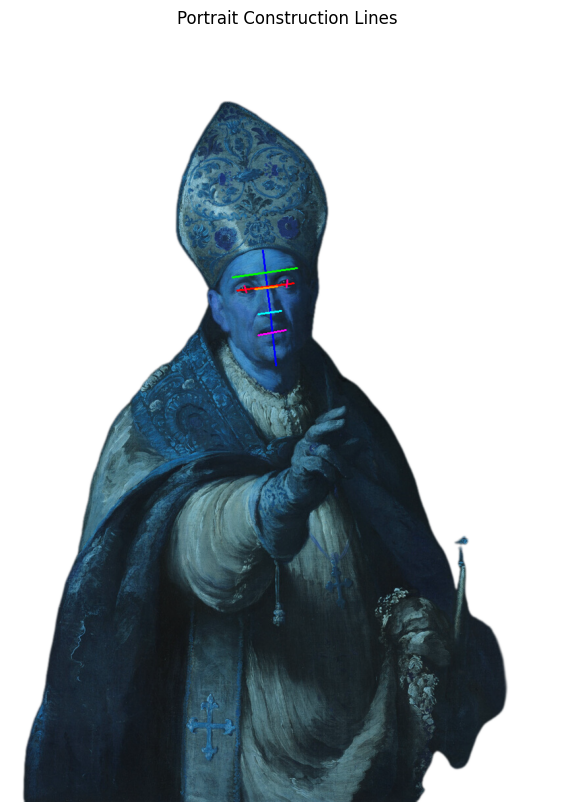


=== Construction Lines Applied ===
Red: Vertical Center Line
Green: Eyebrow Line
Blue/Light Blue/Purple: Eye Lines
Yellow: Nose Line
Magenta: Mouth Line


In [124]:
# Portrait Drawing Construction Lines Implementation
# Based on Portrait_drawing_outlines_connection_rule.md

def draw_construction_lines(image, landmarks, color=(0, 255, 0), thickness=2):
    """
    Draw portrait construction lines based on MediaPipe face landmarks
    following the rules from Portrait_drawing_outlines_connection_rule.md
    """
    if not landmarks:
        return image
    
    annotated = image.copy()
    height, width = image.shape[:2]
    
    def get_pixel_coords(landmark_idx):
        """Convert normalized landmark coordinates to pixel coordinates"""
        if landmark_idx >= len(landmarks):
            return None
        landmark = landmarks[landmark_idx]
        return (int(landmark.x * width), int(landmark.y * height))
    
    def draw_line_between_points(point_indices, line_color=None):
        """Draw line connecting multiple points"""
        if line_color is None:
            line_color = color
            
        points = []
        for idx in point_indices:
            point = get_pixel_coords(idx)
            if point:
                points.append(point)
        
        # Draw line through all points
        for i in range(len(points) - 1):
            cv2.line(annotated, points[i], points[i + 1], line_color, thickness)
        
        return points
    
    # 1. Vertical Center Line [10‚Üí168‚Üí4‚Üí152]
    # Description: contour from the tip of the chin to the ear
    vertical_points = draw_line_between_points([10, 168, 4, 152], (255, 0, 0))  # Red
    print(f"Vertical Center Line points: {len(vertical_points)}")
    
    # 2. Eyebrow Line [63‚Üí293] 
    # Description: The line connecting the two eyebrows
    eyebrow_points = draw_line_between_points([63, 293], (0, 255, 0))  # Green
    print(f"Eyebrow Line points: {len(eyebrow_points)}")
    
    # 3. Eye Line [33‚Üí263], [133‚Üí362], [145‚Üí159], [374‚Üí386]
    # Description: The line connecting the two eyes (most important baseline)
    eye_line_1 = draw_line_between_points([33, 263], (0, 0, 255))  # Blue - outer eye corners
    eye_line_2 = draw_line_between_points([133, 362], (0, 150, 255))  # Light blue - inner eye corners
    eye_line_3 = draw_line_between_points([145, 159], (100, 0, 255))  # Purple
    eye_line_4 = draw_line_between_points([374, 386], (150, 0, 255))  # Purple
    print(f"Eye Lines: {len(eye_line_1)}, {len(eye_line_2)}, {len(eye_line_3)}, {len(eye_line_4)}")
    
    # 4. Nose Line [48‚Üí278]
    # Description: The line that determines the width of the nose tip
    nose_points = draw_line_between_points([48, 278], (255, 255, 0))  # Yellow
    print(f"Nose Line points: {len(nose_points)}")
    
    # 5. Mouth Line [61‚Üí308] (but 308 might not exist, try 291 which is mouth_right)
    # Description: A line that defines the width and height of the mouth
    # Let's try the original 308 first, then fallback to 291
    try:
        mouth_points = draw_line_between_points([61, 308], (255, 0, 255))  # Magenta
        print(f"Mouth Line points (61‚Üí308): {len(mouth_points)}")
    except:
        # Fallback to known mouth_right index 291
        mouth_points = draw_line_between_points([61, 291], (255, 0, 255))  # Magenta
        print(f"Mouth Line points (61‚Üí291): {len(mouth_points)}")
    
    # Add labels for each construction line
    label_color = (255, 255, 255)  # White
    cv2.putText(annotated, "Vertical Center", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Eyebrow Line", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Eye Lines", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Nose Line", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Mouth Line", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    
    return annotated

# Apply construction lines to the detected face
if detection_result.face_landmarks:
    construction_image = draw_construction_lines(image_rgb, landmarks)
    show_image(construction_image, "Portrait Construction Lines", figsize=(14, 10))
    
    print("\n=== Construction Lines Applied ===")
    print("Red: Vertical Center Line")
    print("Green: Eyebrow Line") 
    print("Blue/Light Blue/Purple: Eye Lines")
    print("Yellow: Nose Line")
    print("Magenta: Mouth Line")
else:
    print("No face landmarks detected for construction lines")

In [125]:
# ==========================================
# Wireframe Portrait Generation Functions
# ==========================================

# Method 1: Face Mask-based Removal
def create_face_outline_only(image, landmarks, construction_lines_image):
    """
    ÏñºÍµ¥ Î∂ÄÎ∂ÑÏùÑ Ï†úÍ±∞ÌïòÍ≥† meshÏôÄ construction linesÎßå ÎÇ®Í∏∞Í∏∞ (ÎßàÏä§ÌÅ¨ Í∏∞Î∞ò)
    
    Args:
        image: ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
        landmarks: MediaPipe face landmarks
        construction_lines_image: construction linesÍ∞Ä Í∑∏Î†§ÏßÑ Ïù¥ÎØ∏ÏßÄ
    
    Returns:
        result: RGBA Ïù¥ÎØ∏ÏßÄ (ÏñºÍµ¥ Î∂ÄÎ∂Ñ Ìà¨Î™Ö)
        mask: ÏÇ¨Ïö©Îêú ÎßàÏä§ÌÅ¨
    """
    height, width = image.shape[:2]
    
    # 1. ÏñºÍµ¥ Ïú§Í≥Ω Ìè¨Ïù∏Ìä∏Îì§Î°ú ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± (MediaPipe Face MeshÏùò face oval ÎûúÎìúÎßàÌÅ¨)
    face_oval_points = [
        # ÏñºÍµ¥ Ïô∏Í≥Ω Ïú§Í≥ΩÏÑ† ÎûúÎìúÎßàÌÅ¨ Ïù∏Îç±Ïä§Îì§
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109
    ]
    
    # ÎûúÎìúÎßàÌÅ¨Î•º ÌîΩÏÖÄ Ï¢åÌëúÎ°ú Î≥ÄÌôò
    face_points = []
    for idx in face_oval_points:
        if idx < len(landmarks):
            landmark = landmarks[idx]
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            face_points.append((x, y))
    
    # 2. ÏñºÍµ¥ Ïú§Í≥ΩÏúºÎ°ú ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    mask = np.zeros((height, width), dtype=np.uint8)
    if len(face_points) > 0:
        face_contour = np.array(face_points, dtype=np.int32)
        cv2.fillPoly(mask, [face_contour], 255)
        
        # ÎßàÏä§ÌÅ¨Î•º ÏïΩÍ∞Ñ Ï∂ïÏÜåÌï¥ÏÑú Í≤ΩÍ≥ÑÏÑ†Ïù¥ Ïûò Î≥¥Ïù¥ÎèÑÎ°ù
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=2)
    
    # 3. RGBA Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (Ìà¨Î™ÖÎèÑ Ï±ÑÎÑê Ï∂îÍ∞Ä)
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # 4. ÏñºÍµ¥ ÏòÅÏó≠ÏùÑ Ìà¨Î™ÖÌïòÍ≤å ÎßåÎì§Í∏∞
    result[mask > 0, 3] = 0  # ÏïåÌåå Ï±ÑÎÑêÏùÑ 0ÏúºÎ°ú (ÏôÑÏ†Ñ Ìà¨Î™Ö)
    
    return result, mask

print("‚úÖ Method 1: Face Mask-based Removal function implemented")

‚úÖ Method 1: Face Mask-based Removal function implemented


In [126]:
# Method 2: Color Difference-based Removal
def remove_face_keep_lines(construction_lines_image, original_image, threshold=30):
    """
    ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ ÎπÑÍµêÌï¥ÏÑú Î≥ÄÌôîÍ∞Ä Ï†ÅÏùÄ Î∂ÄÎ∂Ñ(ÏñºÍµ¥)ÏùÄ Ìà¨Î™ÖÌïòÍ≤å ÎßåÎì§Í∏∞
    
    Args:
        construction_lines_image: construction linesÍ∞Ä Í∑∏Î†§ÏßÑ Ïù¥ÎØ∏ÏßÄ
        original_image: ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
        threshold: Î≥ÄÌôî Í∞êÏßÄ ÏûÑÍ≥ÑÍ∞í (ÎÜíÏùÑÏàòÎ°ù Îçî ÎßéÏùÄ Î∂ÄÎ∂ÑÏù¥ Ï†úÍ±∞Îê®)
    
    Returns:
        result: RGBA Ïù¥ÎØ∏ÏßÄ (ÏñºÍµ¥ Î∂ÄÎ∂Ñ Ìà¨Î™Ö)
        line_mask: ÏÑ† ÏòÅÏó≠ ÎßàÏä§ÌÅ¨
    """
    # 1. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ construction lines Ïù¥ÎØ∏ÏßÄÏùò Ï∞®Ïù¥ Í≥ÑÏÇ∞
    diff = cv2.absdiff(construction_lines_image, original_image)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    
    # 2. Î≥ÄÌôîÍ∞Ä ÌÅ∞ Î∂ÄÎ∂Ñ(ÏÑ†Îì§)Îßå ÎßàÏä§ÌÅ¨Î°ú ÎßåÎì§Í∏∞
    _, line_mask = cv2.threshold(diff_gray, threshold, 255, cv2.THRESH_BINARY)
    
    # 3. ÏÑ† ÎßàÏä§ÌÅ¨Î•º Ï°∞Í∏à ÌôïÏû•Ìï¥ÏÑú ÏÑ†Ïù¥ Ïûò Î≥¥Ïù¥ÎèÑÎ°ù
    kernel = np.ones((3,3), np.uint8)
    line_mask = cv2.dilate(line_mask, kernel, iterations=1)
    
    # 4. RGBA Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # 5. ÏÑ†Ïù¥ ÏïÑÎãå Î∂ÄÎ∂ÑÏùÑ Ìà¨Î™ÖÌïòÍ≤å ÎßåÎì§Í∏∞
    result[line_mask == 0, 3] = 0
    
    return result, line_mask

print("‚úÖ Method 2: Color Difference-based Removal function implemented")

‚úÖ Method 2: Color Difference-based Removal function implemented


In [127]:
# Method 3: Color-based Filtering
def extract_colored_lines_only(construction_lines_image, colors_to_keep=None, tolerance=20):
    """
    ÌäπÏ†ï ÏÉâÏÉÅÏùò ÏÑ†Îì§Îßå ÎÇ®Í∏∞Í≥† ÎÇòÎ®∏ÏßÄÎäî Ìà¨Î™ÖÌïòÍ≤å ÎßåÎì§Í∏∞
    
    Args:
        construction_lines_image: construction linesÍ∞Ä Í∑∏Î†§ÏßÑ Ïù¥ÎØ∏ÏßÄ
        colors_to_keep: Î≥¥Ï°¥Ìï† ÏÉâÏÉÅ Î¶¨Ïä§Ìä∏ (RGB)
        tolerance: ÏÉâÏÉÅ ÌóàÏö© Î≤îÏúÑ
    
    Returns:
        result: RGBA Ïù¥ÎØ∏ÏßÄ (ÏÑ† ÏÉâÏÉÅÎßå Î≥¥Ï°¥)
        keep_mask: Î≥¥Ï°¥Îêú ÏòÅÏó≠ ÎßàÏä§ÌÅ¨
    """
    if colors_to_keep is None:
        # construction linesÏóêÏÑú ÏÇ¨Ïö©Ìïú ÏÉâÏÉÅÎì§
        colors_to_keep = [
            (255, 0, 0),    # Red - Vertical Center
            (0, 255, 0),    # Green - Eyebrow Line
            (0, 0, 255),    # Blue - Eye Lines
            (0, 150, 255),  # Light Blue - Eye Lines
            (100, 0, 255),  # Purple - Eye Lines
            (150, 0, 255),  # Purple - Eye Lines
            (255, 255, 0),  # Yellow - Nose Line
            (255, 0, 255),  # Magenta - Mouth Line
            (255, 255, 255) # White - Labels
        ]
    
    # RGBA Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± (Î™®Îì† ÌîΩÏÖÄÏùÑ Ìà¨Î™ÖÌïòÍ≤å ÏãúÏûë)
    keep_mask = np.zeros(construction_lines_image.shape[:2], dtype=bool)
    
    # Í∞Å ÏÉâÏÉÅÏóê ÎåÄÌï¥ ÌóàÏö© Î≤îÏúÑ ÏÑ§Ï†ï
    for color in colors_to_keep:
        # ÏÉâÏÉÅ Î≤îÏúÑ ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
        lower = np.array([max(0, c - tolerance) for c in color])
        upper = np.array([min(255, c + tolerance) for c in color])
        
        color_mask = cv2.inRange(construction_lines_image, lower, upper)
        keep_mask = keep_mask | (color_mask > 0)
    
    # MediaPipe mesh linesÎèÑ Î≥¥Ï°¥ÌïòÍ∏∞ ÏúÑÌï¥ ÌäπÎ≥ÑÌûà Ï≤òÎ¶¨
    # meshÎäî ÏñáÏùÄ ÏÑ†Ïù¥ÎØÄÎ°ú Îçî ÎÑìÏùÄ ÌóàÏö© Î≤îÏúÑÎ°ú ÌÉêÏßÄ
    gray = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2GRAY)
    _, mesh_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # Ïñ¥ÎëêÏö¥ ÏÑ†Îì§ Ï∞æÍ∏∞
    
    # mesh ÏÑ†Îì§ÏùÑ keep_maskÏóê Ï∂îÍ∞Ä
    keep_mask = keep_mask | (mesh_mask > 0)
    
    # Î≥¥Ï°¥Ìï† ÏÉâÏÉÅÏù¥ ÏïÑÎãå Î∂ÄÎ∂ÑÏùÑ Ìà¨Î™ÖÌïòÍ≤å ÎßåÎì§Í∏∞
    result[~keep_mask, 3] = 0
    
    return result, keep_mask.astype(np.uint8) * 255

print("‚úÖ Method 3: Color-based Filtering function implemented")

‚úÖ Method 3: Color-based Filtering function implemented


In [128]:
# Unified Wireframe Portrait Generation Function
def create_wireframe_portrait(image_rgb, landmarks, detection_result, method='face_mask', **kwargs):
    """
    ÏñºÍµ¥Ïùò wireframe(ÏÑ†Ìôî) Î≤ÑÏ†Ñ ÏÉùÏÑ±
    
    Args:
        image_rgb: ÏõêÎ≥∏ RGB Ïù¥ÎØ∏ÏßÄ
        landmarks: MediaPipe face landmarks
        detection_result: MediaPipe detection result
        method: ÏÇ¨Ïö©Ìï† Î∞©Î≤ï ('face_mask', 'color_diff', 'color_filter')
        **kwargs: Í∞Å Î∞©Î≤ïÎ≥Ñ Ï∂îÍ∞Ä Îß§Í∞úÎ≥ÄÏàò
            - face_mask: Îß§Í∞úÎ≥ÄÏàò ÏóÜÏùå
            - color_diff: threshold (Í∏∞Î≥∏Í∞í: 30)
            - color_filter: colors_to_keep, tolerance (Í∏∞Î≥∏Í∞í: 20)
    
    Returns:
        result: RGBA wireframe Ïù¥ÎØ∏ÏßÄ
        mask: ÏÇ¨Ïö©Îêú ÎßàÏä§ÌÅ¨
        construction_image: construction linesÍ∞Ä Í∑∏Î†§ÏßÑ Ï§ëÍ∞Ñ Ïù¥ÎØ∏ÏßÄ
        mesh_image: meshÍ∞Ä Ï∂îÍ∞ÄÎêú Ï§ëÍ∞Ñ Ïù¥ÎØ∏ÏßÄ
    """
    # 1. Construction lines Í∑∏Î¶¨Í∏∞
    construction_image = draw_construction_lines(image_rgb, landmarks)
    
    # 2. Face mesh Í∑∏Î¶¨Í∏∞ (Îçî ÏñáÏùÄ ÏÑ†ÏúºÎ°ú)
    mesh_image = draw_landmarks_on_image(construction_image, detection_result)
    
    # 3. ÏÑ†ÌÉùÌïú Î∞©Î≤ïÏúºÎ°ú ÏñºÍµ¥ Î∂ÄÎ∂Ñ Ï†úÍ±∞
    if method == 'face_mask':
        result, mask = create_face_outline_only(image_rgb, landmarks, mesh_image)
        print("‚úÖ Face Mask Î∞©Î≤ï ÏÇ¨Ïö©")
        
    elif method == 'color_diff':
        threshold = kwargs.get('threshold', 30)
        result, mask = remove_face_keep_lines(mesh_image, image_rgb, threshold)
        print(f"‚úÖ Color Difference Î∞©Î≤ï ÏÇ¨Ïö© (threshold: {threshold})")
    
    elif method == 'color_filter':
        colors_to_keep = kwargs.get('colors_to_keep', None)
        tolerance = kwargs.get('tolerance', 20)
        result, mask = extract_colored_lines_only(mesh_image, colors_to_keep, tolerance)
        print(f"‚úÖ Color Filter Î∞©Î≤ï ÏÇ¨Ïö© (tolerance: {tolerance})")
    
    else:
        print(f"‚ùå Ïïå Ïàò ÏóÜÎäî Î∞©Î≤ï: {method}. Í∏∞Î≥∏ RGBA Î≥ÄÌôòÎßå ÏàòÌñâ.")
        result = cv2.cvtColor(mesh_image, cv2.COLOR_RGB2RGBA)
        mask = None
    
    return result, mask, construction_image, mesh_image

print("‚úÖ Unified wireframe portrait generation function implemented")

‚úÖ Unified wireframe portrait generation function implemented


In [129]:
# RGBA Ïù¥ÎØ∏ÏßÄ ÌëúÏãúÎ•º ÏúÑÌïú Ìó¨Ìçº Ìï®Ïàò
def show_rgba_image(rgba_image, title="RGBA Image", figsize=(12, 8), background_color='white'):
    """RGBA Ïù¥ÎØ∏ÏßÄÎ•º Î∞∞Í≤ΩÍ≥º Ìï®Íªò ÌëúÏãú"""
    if background_color == 'white':
        bg_color = (255, 255, 255)
    elif background_color == 'black':
        bg_color = (0, 0, 0)
    elif background_color == 'checkered':
        # Ï≤¥Ïª§Î≥¥Îìú Î∞∞Í≤Ω ÏÉùÏÑ±
        h, w = rgba_image.shape[:2]
        checker = np.zeros((h, w, 3), dtype=np.uint8)
        checker_size = 20
        for i in range(0, h, checker_size):
            for j in range(0, w, checker_size):
                if (i // checker_size + j // checker_size) % 2 == 0:
                    checker[i:i+checker_size, j:j+checker_size] = (200, 200, 200)
                else:
                    checker[i:i+checker_size, j:j+checker_size] = (255, 255, 255)
        bg_color = None
        background = checker
    else:
        bg_color = (128, 128, 128)  # ÌöåÏÉâ
    
    # ÏïåÌåå Î∏îÎ†åÎî©
    if bg_color is not None:
        background = np.full(rgba_image.shape[:2] + (3,), bg_color, dtype=np.uint8)
    
    alpha = rgba_image[:, :, 3:4] / 255.0
    rgb_part = rgba_image[:, :, :3]
    
    # Î∏îÎ†åÎî©
    blended = (alpha * rgb_part + (1 - alpha) * background).astype(np.uint8)
    
    # ÌëúÏãú
    plt.figure(figsize=figsize)
    plt.imshow(blended)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    # Ìà¨Î™Ö ÌîΩÏÖÄ Ïàò Ï†ïÎ≥¥
    transparent_pixels = np.sum(rgba_image[:, :, 3] == 0)
    total_pixels = rgba_image.shape[0] * rgba_image.shape[1]
    transparency_ratio = transparent_pixels / total_pixels * 100
    print(f"Ìà¨Î™Ö ÌîΩÏÖÄ: {transparent_pixels:,} / {total_pixels:,} ({transparency_ratio:.1f}%)")

def save_wireframe_result(rgba_image, filename, output_dir="../image_processing/out/"):
    """wireframe Í≤∞Í≥ºÎ•º PNGÎ°ú Ï†ÄÏû• (Ìà¨Î™ÖÎèÑ Ïú†ÏßÄ)"""
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # RGBAÎ•º BGRAÎ°ú Î≥ÄÌôò (OpenCV Ï†ÄÏû• ÌòïÏãù)
    bgra_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2BGRA)
    
    filepath = os.path.join(output_dir, filename)
    success = cv2.imwrite(filepath, bgra_image)
    
    if success:
        print(f"‚úÖ Ï†ÄÏû• ÏôÑÎ£å: {filepath}")
    else:
        print(f"‚ùå Ï†ÄÏû• Ïã§Ìå®: {filepath}")
    
    return filepath

print("‚úÖ Helper functions implemented")

‚úÖ Helper functions implemented


üé® Wireframe Portrait ÏÉùÏÑ± ÌÖåÏä§Ìä∏ - 3Í∞ÄÏßÄ Î∞©Î≤ï ÎπÑÍµê

1Ô∏è‚É£ Face Mask Î∞©Î≤ï
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61‚Üí308): 2
‚úÖ Face Mask Î∞©Î≤ï ÏÇ¨Ïö©


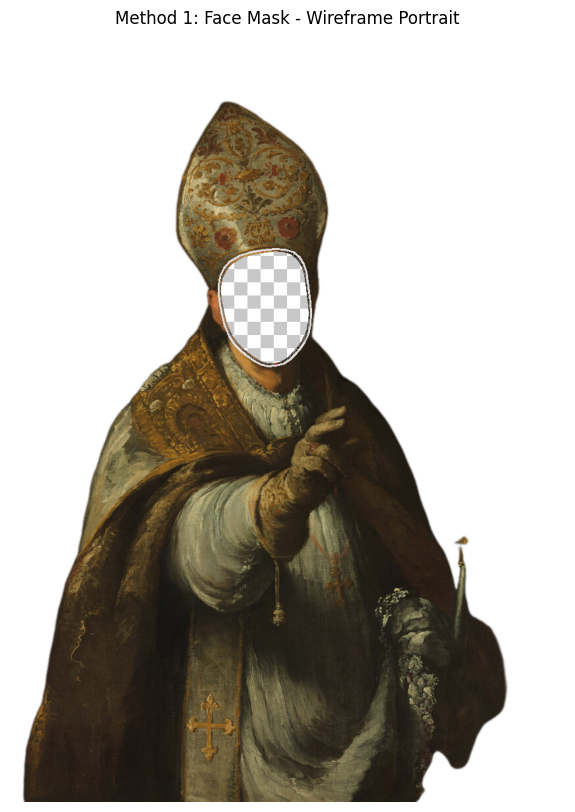

Ìà¨Î™Ö ÌîΩÏÖÄ: 17,775 / 985,467 (1.8%)

2Ô∏è‚É£ Color Difference Î∞©Î≤ï
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61‚Üí308): 2
‚úÖ Color Difference Î∞©Î≤ï ÏÇ¨Ïö© (threshold: 25)


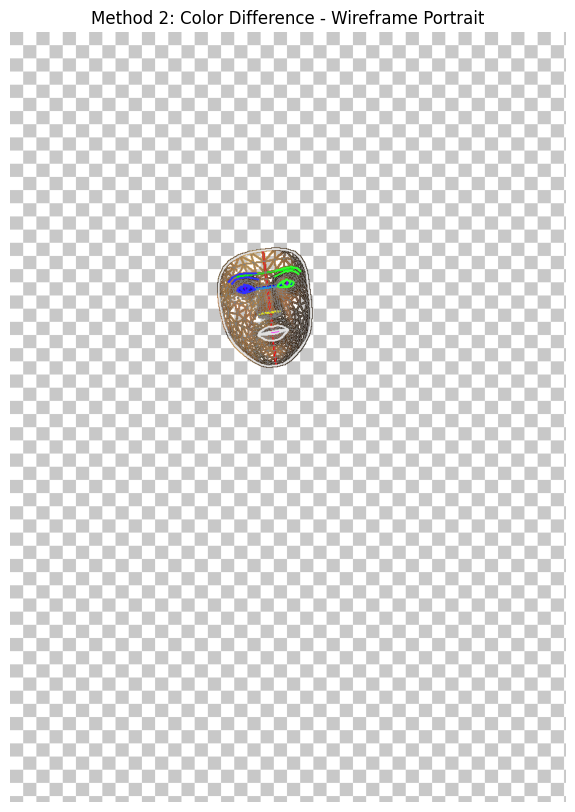

Ìà¨Î™Ö ÌîΩÏÖÄ: 966,413 / 985,467 (98.1%)

3Ô∏è‚É£ Color Filter Î∞©Î≤ï
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61‚Üí308): 2
‚úÖ Color Filter Î∞©Î≤ï ÏÇ¨Ïö© (tolerance: 30)


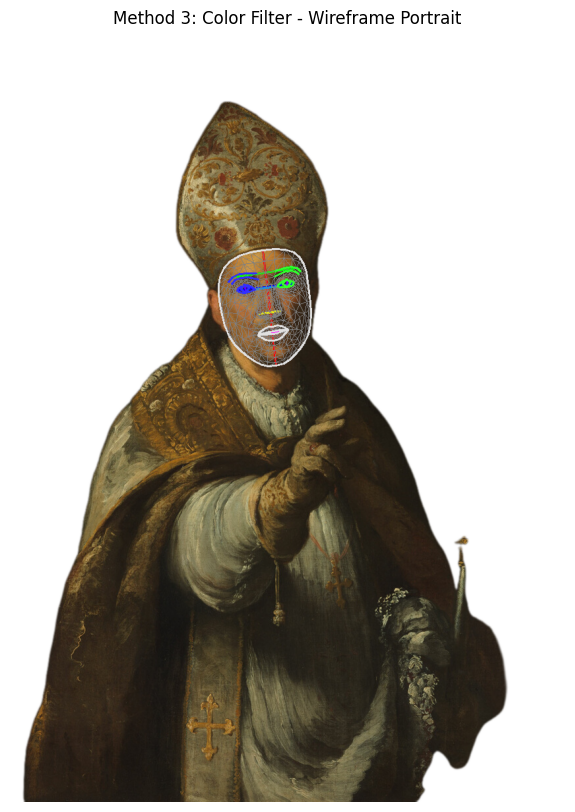

Ìà¨Î™Ö ÌîΩÏÖÄ: 0 / 985,467 (0.0%)

üìä Í≤∞Í≥º ÎπÑÍµê:
- Face Mask: ÏñºÍµ¥ ÌòïÌÉú Í∏∞Î∞òÏúºÎ°ú Ï†ïÌôïÌïú ÎßàÏä§ÌÇπ
- Color Diff: ÏõêÎ≥∏Í≥ºÏùò Ï∞®Ïù¥ Í∏∞Î∞òÏúºÎ°ú ÏÑ†Îßå Î≥¥Ï°¥
- Color Filter: ÌäπÏ†ï ÏÉâÏÉÅÏùò ÏÑ†Îì§Îßå ÏÑ†Î≥ÑÏ†ÅÏúºÎ°ú Î≥¥Ï°¥


In [130]:
# ==========================================
# Test and Compare All Methods
# ==========================================

print("üé® Wireframe Portrait ÏÉùÏÑ± ÌÖåÏä§Ìä∏ - 3Í∞ÄÏßÄ Î∞©Î≤ï ÎπÑÍµê")
print("="*60)

if detection_result.face_landmarks:
    # 1. Method 1: Face Mask-based
    print("\n1Ô∏è‚É£ Face Mask Î∞©Î≤ï")
    wireframe_mask, mask1, construction1, mesh1 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='face_mask'
    )
    show_rgba_image(wireframe_mask, "Method 1: Face Mask - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    # 2. Method 2: Color Difference-based
    print("\n2Ô∏è‚É£ Color Difference Î∞©Î≤ï")
    wireframe_diff, mask2, construction2, mesh2 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='color_diff', threshold=25
    )
    show_rgba_image(wireframe_diff, "Method 2: Color Difference - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    # 3. Method 3: Color Filtering-based
    print("\n3Ô∏è‚É£ Color Filter Î∞©Î≤ï")
    wireframe_filter, mask3, construction3, mesh3 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='color_filter', tolerance=30
    )
    show_rgba_image(wireframe_filter, "Method 3: Color Filter - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    print("\nüìä Í≤∞Í≥º ÎπÑÍµê:")
    print("- Face Mask: ÏñºÍµ¥ ÌòïÌÉú Í∏∞Î∞òÏúºÎ°ú Ï†ïÌôïÌïú ÎßàÏä§ÌÇπ")
    print("- Color Diff: ÏõêÎ≥∏Í≥ºÏùò Ï∞®Ïù¥ Í∏∞Î∞òÏúºÎ°ú ÏÑ†Îßå Î≥¥Ï°¥")
    print("- Color Filter: ÌäπÏ†ï ÏÉâÏÉÅÏùò ÏÑ†Îì§Îßå ÏÑ†Î≥ÑÏ†ÅÏúºÎ°ú Î≥¥Ï°¥")
    
else:
    print("‚ùå ÏñºÍµ¥Ïù¥ Í∞êÏßÄÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")

üîß ÏµúÏ¢Ö Wireframe Portrait ÏÉùÏÑ± Î∞è Ï†ÄÏû•

üé≠ Face Mask Î∞©Î≤ï (Í∂åÏû•)
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61‚Üí308): 2
‚úÖ Face Mask Î∞©Î≤ï ÏÇ¨Ïö©


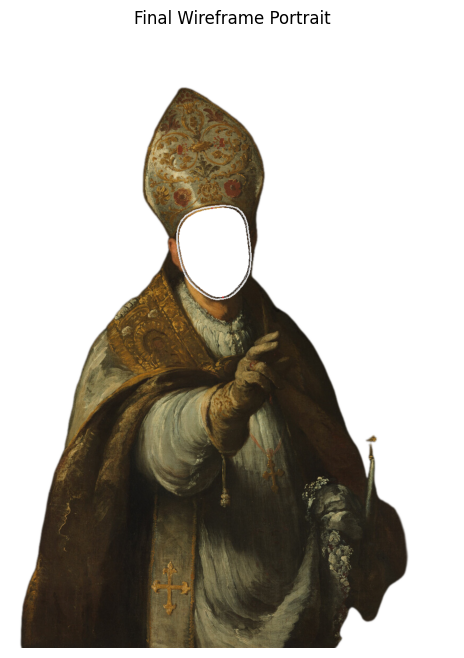

Ìà¨Î™Ö ÌîΩÏÖÄ: 17,775 / 985,467 (1.8%)
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: ../image_processing/out/portrait_wireframe.png

üñ§ Í≤ÄÏùÄ Î∞∞Í≤ΩÏóêÏÑúÏùò Î™®Ïäµ:


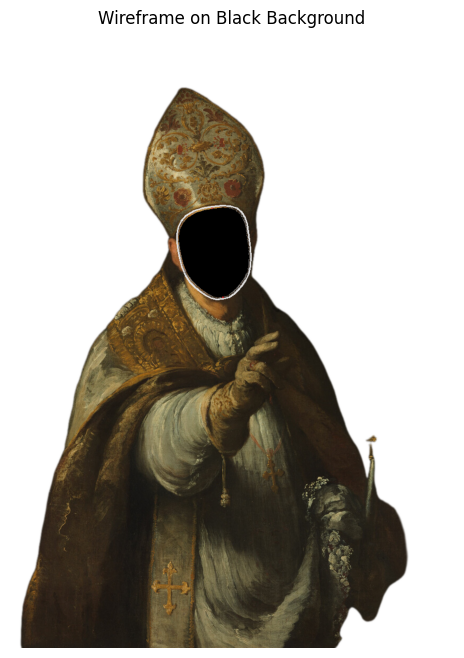

Ìà¨Î™Ö ÌîΩÏÖÄ: 17,775 / 985,467 (1.8%)

üí° ÏÇ¨Ïö© ÌåÅ:
- Face Mask Î∞©Î≤ïÏù¥ Í∞ÄÏû• Ï†ïÌôïÌïòÍ≥† ÏùºÍ¥ÄÎêú Í≤∞Í≥ºÎ•º Ï†úÍ≥µÌï©ÎãàÎã§
- PNG ÌòïÌÉúÎ°ú Ï†ÄÏû•ÌïòÎ©¥ Ìà¨Î™ÖÎèÑÍ∞Ä Î≥¥Ï°¥Îê©ÎãàÎã§
- Îã§ÏñëÌïú Î∞∞Í≤ΩÏóê Ìï©ÏÑ±Ìï† Ïàò ÏûàÏäµÎãàÎã§
- Î≤°ÌÑ∞ Í∑∏ÎûòÌîΩÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ SVGÎ°ú Ï†ÄÏû•ÎèÑ Í∞ÄÎä•Ìï©ÎãàÎã§


In [131]:
# ==========================================
# Final Wireframe with Save Functionality
# ==========================================

print("üîß ÏµúÏ¢Ö Wireframe Portrait ÏÉùÏÑ± Î∞è Ï†ÄÏû•")
print("="*40)

if detection_result.face_landmarks:
    # Face Mask Î∞©Î≤ï (Í∂åÏû•)
    print("\nüé≠ Face Mask Î∞©Î≤ï (Í∂åÏû•)")
    wireframe_final, _, _, _ = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='face_mask'
    )
    show_rgba_image(wireframe_final, "Final Wireframe Portrait", 
                   figsize=(12, 8), background_color='white')
    
    # Í≤∞Í≥º Ï†ÄÏû•
    save_wireframe_result(wireframe_final, "portrait_wireframe.png")
    
    # Îã§Î•∏ Î∞∞Í≤ΩÏÉâÏúºÎ°úÎèÑ ÌôïÏù∏
    print("\nüñ§ Í≤ÄÏùÄ Î∞∞Í≤ΩÏóêÏÑúÏùò Î™®Ïäµ:")
    show_rgba_image(wireframe_final, "Wireframe on Black Background", 
                   figsize=(12, 8), background_color='black')
    
    print("\n" + "="*50)
    print("üí° ÏÇ¨Ïö© ÌåÅ:")
    print("- Face Mask Î∞©Î≤ïÏù¥ Í∞ÄÏû• Ï†ïÌôïÌïòÍ≥† ÏùºÍ¥ÄÎêú Í≤∞Í≥ºÎ•º Ï†úÍ≥µÌï©ÎãàÎã§")
    print("- PNG ÌòïÌÉúÎ°ú Ï†ÄÏû•ÌïòÎ©¥ Ìà¨Î™ÖÎèÑÍ∞Ä Î≥¥Ï°¥Îê©ÎãàÎã§")
    print("- Îã§ÏñëÌïú Î∞∞Í≤ΩÏóê Ìï©ÏÑ±Ìï† Ïàò ÏûàÏäµÎãàÎã§")
    print("- Î≤°ÌÑ∞ Í∑∏ÎûòÌîΩÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ SVGÎ°ú Ï†ÄÏû•ÎèÑ Í∞ÄÎä•Ìï©ÎãàÎã§")
    
else:
    print("‚ùå ÏñºÍµ¥Ïù¥ Í∞êÏßÄÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")